> May 06, 2024 | {sub-ref}`wordcount-minutes` min read




In [1]:
# General libraries
from utils.hamiltonian_utils import ising_chain_ham
from utils.rotosolve_optimizer import Rotosolve
from scipy.ndimage import gaussian_filter
import json
from styles.style import qspain
from IPython.display import Latex
from IPython import display
import matplotlib.pyplot as plt
import warnings
import numpy as np

# Qiskit libraries
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit import transpile
from qiskit.algorithms.optimizers import SPSA
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeLima
from qiskit_aer import QasmSimulator
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit_ibm_provider import least_busy
from qiskit_ibm_provider import IBMProvider as IBMQ
import qiskit.tools.jupyter

warnings.filterwarnings("ignore")
%matplotlib inline

(sec_Algoritmo_de_optimización_Rotosolve)= 
# Algoritmo de optimización Rotosolve

:::{contents}
:local:
:depth: 1
:::


(sec_Fundamento_teórico_del_optimizador_Rotosolve)= 
## Fundamento teórico del optimizador Rotosolve

El algoritmo de optimización <b>Rotosolve</b> es un algoritmo <i>quantum-aware</i>, ya que dicho algoritmo esta optimizado para obtener las mejores resultados sobre hardware de ordenadores cuánticos.


Este algoritmo de optimización es uno más de los posibles algoritmos que se pueden usar en circuitos variacionales (parametrizados) cuánticos. En esencia, el optimizador Rotosolve minimiza una función objetivo con respecto a los parámetros de un circuito cuántico sin necesidad de calcular el gradiente de la función. El algoritmo realiza iteraciones en los que actualiza los parámetros del circuito $\theta = \theta_1, \dots, \theta_D$ con la función de coste hasta completar el número máximo de iteraciones.


Este algoritmo de optimización hace descender el valor inicial de manera drástica, alcanzando el valor mínimo en pocas iteraciones.


El código del algoritmo Rotosolve se encuentra en el archivo <a href="./utils/rotosolve_optimizer.py">rotosolve_optimizer.py</a>.

In [2]:
# Vista del archivo rotosolve_optimizer.py
display.Code("./utils/rotosolve_optimizer.py")

"""
Created by: QuantumSpain (https://quantumspain-project.es/)
"""
from qiskit.algorithms.optimizers.optimizer import Optimizer, OptimizerSupportLevel, OptimizerResult
import numpy as np
from typing import Dict, Any

class Rotosolve(Optimizer):
    """Create an instance of the Rotosolve optimizer.
    Parameters
    ----------
    max_steps : int
        Maximum number of steps to take in the optimizer. This is the number
        of times to loop through all the parameters in the objective function.
    alt_convention : bool
        The Rotosolve paper uses the convention that there is a `1/2`
        in the exponent. This convention corresponds to `alt_convention=False`.
        In other algorithms this factor is
        not present, in which case, use `alt_convention=True`.
    step_size : int
        The step count in the value optimization loop.
    See: https://arxiv.org/abs/1905.09692
    """

    CONFIGURATION = {
        'name': 'RotoSolve',
        'description': 'RotoSolve Optimizer',
        'input_schema': {
            '$schema': 'http://json-schema.org/schema#',
            'id': 'GP_schema',
            'type': 'object',
            'properties': {},
            'additionalProperties': False
        },
        'support_level': {
            'gradient': OptimizerSupportLevel.ignored,
            'bounds': OptimizerSupportLevel.ignored,
            'initial_point': OptimizerSupportLevel.supported
        },
        'options': [],
        'optimizer': [],
        'maxiter': 1024
    }

    def __init__(self, max_steps: int = 10, step_size: int = 1, alt_convention: bool = False):
        
        super().__init__()
        
        self._max_steps = max_steps
        self._step_size = step_size
        
        # alt_convention == False:
        # e^{-i H theta}
        # alt_convention == True
        # e^{-i H theta/2}
        self._alt_convention = alt_convention

    def optimize(self, num_vars, obj_function, gradient_function=None, variable_bounds=None, initial_point=None):
        """See `qiskit.algorithms.optimizers.optimizer.Optimizer` documentation."""
        super().optimize(num_vars, obj_function, gradient_function, variable_bounds, initial_point)

        if initial_point is None:
            initial_point = np.random.uniform(-np.pi, +np.pi, num_vars)
            
        return self.minimize(fun = obj_function, x0 = initial_point)

    def minimize(self, fun, x0, bounds = None, jac = None):
    
        factor = 2 if self._alt_convention else 1

        def f(x):
            return fun(x / factor)
        
        theta_min, f_min, f_evals, f_values =  self._rotosolve(f, x0, self._max_steps, self._step_size)
        
        self.energy_values = f_values
        
        result = OptimizerResult()
        result.x = theta_min # optimal parameters
        result.fun = f_min # optimal function value
        result.nfev = f_evals

        return result
    
    @staticmethod
    def _rotosolve(f, initial_point: np.array, max_steps: int, step_size: int):
        
        D = len(initial_point)
        theta = initial_point
        f_evals = 0
        
        def f_counter(*args, **kwargs):
            return f(*args, **kwargs)

        f_current = f_counter(initial_point)
        f_evals += 1
        
        converged = False
        steps = 0

        theta_values = []
        f_values = []
        
        print("Rotosolve algorithm for optimizing a given value")
        print("================================================")
        
        while not converged:
            
            for d in range(D):
                
                phi = np.random.uniform(-np.pi, +np.pi)
                theta_d = phi
                theta[d] = theta_d
                m_vals = {
                    'phi+0': 0,
                    'phi+pi/2': 0,
                    'phi-pi/2': 0
                }

                m_vals['phi+0'] = f_counter(theta)
                f_evals += 1
                theta[d] = theta[d]

El algoritmo <b>Rotosolve</b>{cite}`bib_jtilly_variational_2022`,{cite}`bib_mostaszewski_variational_2021`,{cite}`bib_jvidal_parameterized_2018`,{cite}`bib_dwierichs_parameter_2022` actúa de la siguiente forma, toma una puerta parametrizada de nuestro circuito de función de onda (<i>ansatz</i>) y ajusta su ángulo y dirección de rotación para obtener el valor de mínima energía. Este proceso se realiza iterativamente con cada una de las puertas parametrizadas, una vez el algoritmo de optimización ajusta la última puerta parametrizada repite el proceso hasta converger al valor mínimo. 

$\newcommand{\argmin}{\mathrm{arg}\;\mathrm{min}}$

Consideremos un problema de optimización donde la función objetivo es un operador hermítico $M$ y la solución candidata se codifica en un circuito cuántico parametrizado $U = U_D \dots U_1$ que actúa sobre un estado inicial $\rho$ de n-qubits.


Cada puerta del circuito esta parametrizada de la forma $\text{exp}(-i\frac{\theta_d}{2}H_d)$, donde el ángulo de rotación $\theta \in (-\pi, \pi]$ y donde $H_d$ son matrices <b>unitarias</b> y <b>hermíticas</b>. Con todo ello, y sin pérdida de generalidad, minimizaremos la función objetivo a la que simplemente nos referiremos a ella como <i>la energía</i>. Matemáticamente, podemos plantear el problema como: 

$$
(\theta^{\ast}, H^{\ast}) = \argmin_{\theta, H}\ {\langle{H}\rangle}_{\theta, H},\ \text{donde}\ {\langle{H}\rangle}_{\theta, H} = tr(MU\rho U^\dagger)
$$

Disponemos de dos formas de solucionar el planteamiento matemático, una primera forma en la que optimizamos los ángulos de las puertas parametrizadas dejando invariante al circuito y una segunda forma en la que optimizamos simultaneamente el circuito y los ángulos de las puertas parametrizadas, esta última solución se denomina <b>Rotoselect</b>.


Rotoselect hace uso del algoritmo Rotosolve para obtener el valor óptimo del ángulo de cada una de las puertas parametrizadas. 


Seleccionaremos la primera opción expuesta por ser la solución usada en el algoritmo <b>Rotosolve</b>.

$\newcommand{\argmin}{\mathrm{arg}\;\mathrm{min}}$
En la primera solución (Rotosolve), tomamos el ángulo de la primera puerta para su optimización dejando las demás puertas fijas, de tal manera que este proceso se repite de forma secuencial pasando por todas las puertas parametrizadas. Esto es bastante simple de realizar ya que en cada paso secuencial la energía tiene una forma sinusoidal con un periodo de $2\pi$. Por ejemplo, para la puerta $U_d$ el ángulo óptimo se calcula de la siguiente forma: 


$$
\begin{align*}
\theta_{d}^* &= \argmin_{\theta_d} {\langle{M}\rangle}_{\theta_d} = \phi - \tfrac{\pi}{2} - \text{arctan2}\big(2{\langle{M}\rangle}_{\phi} - {\langle{M}\rangle}_{\phi+\frac{\pi}{2}} - {\langle{M}\rangle}_{\phi-\frac{\pi}{2}} , ~ {\langle{M}\rangle}_{\phi+\frac{\pi}{2}} - {\langle{M}\rangle}_{\phi-\frac{\pi}{2}} \big) + 2\pi k
\end{align*}
$$


Esta expresión se cumple para cualquier número real $\phi$ y cualquier número entero $k$. En la práctica seleccionamos un valor de $k$ tal que $\theta_d^* \in (-\pi, \pi]$.


El ángulo óptimo se puede encontrar para todo $d = 1, \dots D$ hasta completar el ciclo de puertas parametrizadas. Una vez todos los ángulos se han actualizado, se inicia un nuevo ciclo de optimización a menos que se cumpla un cierto criterio de parada.

(sec_Modelo_de_Ising_1D_con_optimizador_Rotosolve)= 
## Modelo de Ising 1D con optimizador Rotosolve

Para ejemplificar el algoritmo de optimización Rotosolve, tomaremos el mismo Hamiltoniano del Modelo de Ising 1D descrito en el <i>notebook</i> de <a href="../Chapter_01_Introduction.ipynb#sec_El_Modelo_de_Ising_con_el_algoritmo_VQE">Introducción al algoritmo VQE</a>, usaremos el mismo número de espínes ($n = 4$) y el mismo valor de $\gamma = 0.3$: 

$$
\mathcal{H} = X_1X_2I_3I_4 + I_1X_2X_3I_4 + I_1I_2X_3X_4 + X_1I_2I_3X_4 + \gamma (Z_1I_2I_3I_4 + I_1Z_2I_3I_4 + I_1I_2Z_3I_4 + I_1I_2I_3Z_4)
$$


En este caso usaremos el algoritmo de optimización <b>Rotosolve</b> y compararemos los resultados con el valor obtenido con anterioridad en el <i>notebook</i> introductorio al algoritmo VQE</a>.

Codificamos el hamiltoniano en Qiskit como un operador y preparamos un ansatz TwoLocal ya implementado en esta librería.

:::::{tab-set}
::::{tab-item} Qiskit
```python

# Definimos el Hamiltoniano
n = 4 
gam = 0.3

op_H = ising_chain_ham(n, gam) # Creamos el Hamiltoniano descrito

ansatz = TwoLocal(num_qubits=n, rotation_blocks='ry', entanglement_blocks='cx')
ansatz.draw('mpl', style='iqx')

ansatz.decompose().draw('mpl', style='iqx')
```
::::
:::::


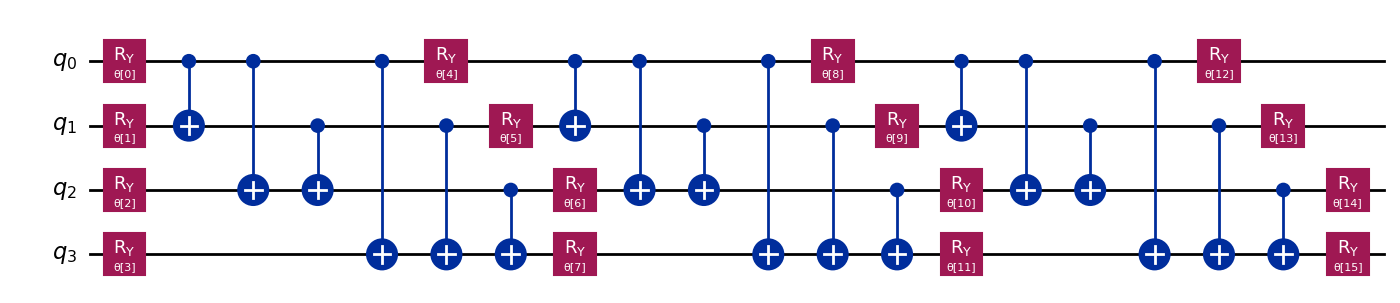

In [3]:
'''Qiskit_code_cell'''

# Definimos el Hamiltoniano
n = 4 
gam = 0.3

op_H = ising_chain_ham(n, gam) # Creamos el Hamiltoniano descrito

ansatz = TwoLocal(num_qubits=n, rotation_blocks='ry', entanglement_blocks='cx')
ansatz.draw('mpl', style='iqx')

ansatz.decompose().draw('mpl', style='iqx')

El siguiente paso es hacer una llamada al solucionador VQE pasándole el hamiltoniano, el ansatz y un optimizador. En este caso hemos implementado el operador Rotosolve[[2]](bib_mostaszewski_variational_2021) para Qiskit

:::::{tab-set}
::::{tab-item} Qiskit
```python

seed = 63
np.random.seed(seed) # seed for reproducibility
algorithm_globals.random_seed = seed

# Instanciamos la clase Rotosolve con 200 iteraciones como máximo y un paso de 3
# en total serán 200/3 = 66 iteraciones
optimizer = Rotosolve(max_steps = 200, step_size = 3)

initial_point = np.random.random(ansatz.num_parameters) # valor inicial

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'mean': [],
    #'stddev': []
}

def callback(nfev, parameters, mean, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['mean'].append(mean)
    #intermediate_info['stddev'].append(stddev)

backend = Aer.get_backend('aer_simulator')

qi = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

vqe_min = VQE(estimator = Estimator(),
           ansatz=ansatz,
           optimizer=optimizer,
           initial_point=initial_point,
           callback=callback)

vqe_min.quantum_instance = qi

result = vqe_min.compute_minimum_eigenvalue(op_H)

print('\nEigenvalue:', result.eigenvalue)
print('Eigenvalue real part:', result.eigenvalue.real)

print(result, "\n")
print("E_G =", result.optimal_value)
```
::::
:::::


In [4]:
'''Qiskit_code_cell'''

seed = 63
np.random.seed(seed) # seed for reproducibility
algorithm_globals.random_seed = seed

# Instanciamos la clase Rotosolve con 200 iteraciones como máximo y un paso de 3
# en total serán 200/3 = 66 iteraciones
optimizer = Rotosolve(max_steps = 200, step_size = 3)

initial_point = np.random.random(ansatz.num_parameters) # valor inicial

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'mean': [],
    #'stddev': []
}

def callback(nfev, parameters, mean, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['mean'].append(mean)
    #intermediate_info['stddev'].append(stddev)

backend = Aer.get_backend('aer_simulator')

qi = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

vqe_min = VQE(estimator = Estimator(),
           ansatz=ansatz,
           optimizer=optimizer,
           initial_point=initial_point,
           callback=callback)

vqe_min.quantum_instance = qi

result = vqe_min.compute_minimum_eigenvalue(op_H)

print('\nEigenvalue:', result.eigenvalue)
print('Eigenvalue real part:', result.eigenvalue.real)

print(result, "\n")
print("E_G =", result.optimal_value)

Rotosolve algorithm for optimizing a given value
Step 0. Current expectation value: -3.86172400


Step 3. Current expectation value: -4.06494515
Step 6. Current expectation value: -4.08179742


Step 9. Current expectation value: -4.08555553
Step 12. Current expectation value: -4.08710498


Step 15. Current expectation value: -4.08812628
Step 18. Current expectation value: -4.08886023


Step 21. Current expectation value: -4.08937372
Step 24. Current expectation value: -4.08972181


Step 27. Current expectation value: -4.08995283
Step 30. Current expectation value: -4.09010424


Step 33. Current expectation value: -4.09020279
Step 36. Current expectation value: -4.09026674


Step 39. Current expectation value: -4.09030819
Step 42. Current expectation value: -4.09033508


Step 45. Current expectation value: -4.09035256
Step 48. Current expectation value: -4.09036394


Step 51. Current expectation value: -4.09037137
Step 54. Current expectation value: -4.09037623


Step 57. Current expectation value: -4.09037943
Step 60. Current expectation value: -4.09038153


Step 63. Current expectation value: -4.09038292
Step 66. Current expectation value: -4.09038385


Step 69. Current expectation value: -4.09038446
Step 72. Current expectation value: -4.09038487


Step 75. Current expectation value: -4.09038514
Step 78. Current expectation value: -4.09038532


Step 81. Current expectation value: -4.09038544
Step 84. Current expectation value: -4.09038552


Step 87. Current expectation value: -4.09038558
Step 90. Current expectation value: -4.09038562


Step 93. Current expectation value: -4.09038564
Step 96. Current expectation value: -4.09038566


Step 99. Current expectation value: -4.09038567
Step 102. Current expectation value: -4.09038568


Step 105. Current expectation value: -4.09038568
Step 108. Current expectation value: -4.09038569


Step 111. Current expectation value: -4.09038569
Step 114. Current expectation value: -4.09038569


Step 117. Current expectation value: -4.09038569
Step 120. Current expectation value: -4.09038569


Step 123. Current expectation value: -4.09038569
Step 126. Current expectation value: -4.09038569


Step 129. Current expectation value: -4.09038569
Step 132. Current expectation value: -4.09038569


Step 135. Current expectation value: -4.09038569
Step 138. Current expectation value: -4.09038569


Step 141. Current expectation value: -4.09038569
Step 144. Current expectation value: -4.09038569


Step 147. Current expectation value: -4.09038569
Step 150. Current expectation value: -4.09038569


Step 153. Current expectation value: -4.09038569
Step 156. Current expectation value: -4.09038569


Step 159. Current expectation value: -4.09038569
Step 162. Current expectation value: -4.09038569


Step 165. Current expectation value: -4.09038569
Step 168. Current expectation value: -4.09038569


Step 171. Current expectation value: -4.09038569
Step 174. Current expectation value: -4.09038569


Step 177. Current expectation value: -4.09038569
Step 180. Current expectation value: -4.09038569


Step 183. Current expectation value: -4.09038569
Step 186. Current expectation value: -4.09038569


Step 189. Current expectation value: -4.09038569
Step 192. Current expectation value: -4.09038569


Step 195. Current expectation value: -4.09038569
Step 198. Current expectation value: -4.09038569

Eigenvalue: -4.090385692923965
Eigenvalue real part: -4.090385692923965
{   'aux_operators_evaluated': None,
    'cost_function_evals': 3218,
    'eigenvalue': -4.090385692923965,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7f628255cfd0>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 3.1363336731589193,
                              ParameterVectorElement(θ[4]): 0.0012340330691393842,
                              ParameterVectorElement(θ[14]): 0.8071925311464565,
                              ParameterVectorElement(θ[13]): 0.13749721982322427,
                              ParameterVectorElement(θ[12]): 0.8729448109274336,
                              ParameterVectorElement(θ[11]): 0.007423521393656471,
                              ParameterVectorElement(θ[10]): -6.064214646764594,
                              ParameterVectorElem

Podemos mostrar la evolución de la convergencia del operador en una gráfica:

:::::{tab-set}
::::{tab-item} Qiskit
```python

sim_values = optimizer.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_values)), sim_values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Rotosolve optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()
```
::::
:::::


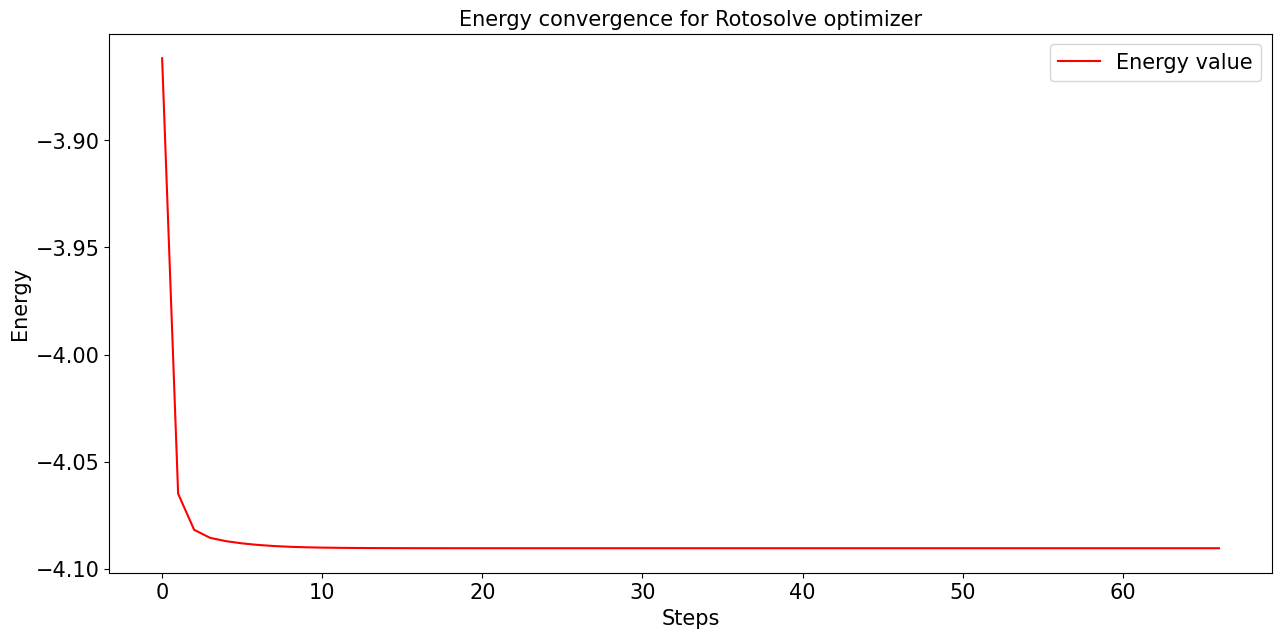

In [5]:
'''Qiskit_code_cell'''

sim_values = optimizer.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_values)), sim_values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Rotosolve optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

En la gráfica podemos ver que el valor mínimo se alcanza con pocas iteraciones, la aproximación es bastante buena pero no mejora el valor obtenido con el algoritmo de optimización <b>SPSA</b> usado en el <i>notebook</i> de <a href="../Chapter_01_Introduction.ipynb#sec_El_Modelo_de_Ising_con_el_algoritmo_VQE">Introducción al algoritmo VQE</a>.


<table style='margin: 0 auto; font-size:11pt'>
  <tr>
      <th></th>
      <th style="text-align:center">Energía mínima <br/>(autovalor)</th>
  </tr>
  <tr>
    <td style="text-align:center"><b>SPSA</b></td>
    <td style="text-align:center">-4.092961599426855</td>
  </tr>
  <tr>
    <td style="text-align:center"><b>Rotosolve ideal</b></td>
    <td style="text-align:center">-4.090385692923965</td>
  </tr>
</table> 


La selección del algoritmo de optimización es una decisión difícil de tomar, en algunas ocasiones se necesita un valor más exacto y en otras ocasiones con una aproximación es suficiente, además el tiempo de cómputo también influye en la selección del algoritmo de optimización lo cual también viene relacionado con la cantidad de recursos <i>hardware</i> que se dispongan.

(sec_Ejecución_de_VQE_en_computador_cuántico_real)= 
### Ejecución de VQE en computador cuántico real

Creamos la configuración inicial para ejecutar nuestro código en un ordenador real de IBM. Para que los cálculos sean más rápidos usamos un backend falso llamado **ibmq_lima**, además haremos uso de los datos de una ejecución anterior para que el proceso no tarde en ejecutarse indefinidamente.


Los ordenadores cuánticos de IBM estan abiertos a todos los usuarios, por ello hay una cola de ejecución que puede demorar la obtención de los resultados.

:::::{tab-set}
::::{tab-item} Qiskit
```python

# Incluye aquí el token personal de ibmq --> https://quantum-computing.ibm.com/
QISKIT_TOKEN = "" 

# Configuración de ejecución
CONFIGURATION = {
    'USE_REAL_BACKEND_NOISE': False, # Usa o no el backend real de ibmq_lima para obtener el ruido del dispositivo para la simulacion VQE
    'JSON_RESULT': True, # Usa los resultados obtenidos de una ejecución previa del algoritmo VQE en el dispositivo real ibmq_lima, desactivar esta opción puede hacer que la ejecución de VQE tarde horas
}
```
::::
:::::


In [6]:
'''Qiskit_code_cell'''

# Incluye aquí el token personal de ibmq --> https://quantum-computing.ibm.com/
QISKIT_TOKEN = "" 

# Configuración de ejecución
CONFIGURATION = {
    'USE_REAL_BACKEND_NOISE': False, # Usa o no el backend real de ibmq_lima para obtener el ruido del dispositivo para la simulacion VQE
    'JSON_RESULT': True, # Usa los resultados obtenidos de una ejecución previa del algoritmo VQE en el dispositivo real ibmq_lima, desactivar esta opción puede hacer que la ejecución de VQE tarde horas
}

Nos conectamos al ordenador cuántico real o no en función de la configuración seleccionada:

:::::{tab-set}
::::{tab-item} Qiskit
```python

if not CONFIGURATION['USE_REAL_BACKEND_NOISE']:
    
    # Use FakeLima device (fake device)
    print("Using fake ibmq_lima device...\n")
        
    device_backend = FakeLima()
    backend = QasmSimulator.from_backend(device_backend)
    
else:

    if QISKIT_TOKEN != "":
        IBMQ.save_account(QISKIT_TOKEN, overwrite=True)
        print("Token IBMQ guardado!")
    #else:
    #    pass # Skip token check
    #    raise("Token no encontrado. Regístrate en https://quantum-computing.ibm.com/ para obtener el token y usar un backend real")
        
    print("Token activo!\n")
    
    provider = IBMQ()

    provider.backends(simulator=False, operational=True)

    print("Provider seleccionado: ", provider.active_account()['instance'])

    # Seleccionamos el backend que este disponible acorde a nuestra configuración
    #backend = least_busy(provider.backends(filters = lambda b: b.configuration().n_qubits >= n and 
    #                                             b.status().operational and not b.configuration().simulator))

    # Obtenemos el backend ibmq_lima
    backend = provider.get_backend('ibm_osaka')

    # Use ibmq_lima real device
    print("\nUsando el backend '%s'..." % (backend.configuration().backend_name))
```
::::
:::::


In [7]:
'''Qiskit_code_cell'''

if not CONFIGURATION['USE_REAL_BACKEND_NOISE']:
    
    # Use FakeLima device (fake device)
    print("Using fake ibmq_lima device...\n")
        
    device_backend = FakeLima()
    backend = QasmSimulator.from_backend(device_backend)
    
else:

    if QISKIT_TOKEN != "":
        IBMQ.save_account(QISKIT_TOKEN, overwrite=True)
        print("Token IBMQ guardado!")
    #else:
    #    pass # Skip token check
    #    raise("Token no encontrado. Regístrate en https://quantum-computing.ibm.com/ para obtener el token y usar un backend real")
        
    print("Token activo!\n")
    
    provider = IBMQ()

    provider.backends(simulator=False, operational=True)

    print("Provider seleccionado: ", provider.active_account()['instance'])

    # Seleccionamos el backend que este disponible acorde a nuestra configuración
    #backend = least_busy(provider.backends(filters = lambda b: b.configuration().n_qubits >= n and 
    #                                             b.status().operational and not b.configuration().simulator))

    # Obtenemos el backend ibmq_lima
    backend = provider.get_backend('ibm_osaka')

    # Use ibmq_lima real device
    print("\nUsando el backend '%s'..." % (backend.configuration().backend_name))

Using fake ibmq_lima device...



Obtenemos los datos de una ejecución previa de nuestro circuito cuántico y obtenemos la energía de convergencia:

:::::{tab-set}
::::{tab-item} Qiskit
```python

# El proceso de procesado de VQE en un computador cuántico real es my costoso (puede durar horas) y tiene timeout en el servidor
# podemos cargar los resultados de una ejecución previa de VQE preparado en un JSON
if not CONFIGURATION['JSON_RESULT']:

    intermediate_info = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        #'stddev': []
    }
    
    def callback(nfev, parameters, mean, stddev):
        intermediate_info['nfev'].append(nfev)
        intermediate_info['parameters'].append(parameters)
        intermediate_info['energy'].append(mean)
        #intermediate_info['stddev'].append(stddev)
    
    basis_gates = backend.configuration().basis_gates
    
    # Transpilación del circuito ansatz para su representación en función de las puertas base del backend
    trans_ansatz = transpile(ansatz, basis_gates = basis_gates, optimization_level = 0)

    # No podemos enviar el algoritmo rotosolve a un ordenador real porque qiskit no lo tiene implementado
    # si enviamos el programa de VQE con rotosolve nos devolverá un error 
    optimizer_real = SPSA(maxiter = 300)
    
    vqe_min_real = VQE(estimator = Estimator(),
                       ansatz = trans_ansatz,
                       optimizer = optimizer_real, 
                       initial_point = initial_point,
                       callback = callback)
    
    vqe_min_real.quantum_instance = QuantumInstance(backend, seed_transpiler=63, seed_simulator=63)
    
    result = vqe_min_real.compute_minimum_eigenvalue(op_H)
    eigenvalue = result.eigenvalue
    optimal_value = result.optimal_value
    
else:

    # Ejecución previa de VQE con SPSA y 300 iteraciones en el backend ibmq_osaka
    # Recuperamos la ejecución, job id: cf5f7poi10jrivgn92ag
    with open('./utils/results/cf5f7poi10jrivgn92ag-result.json') as user_file:
        json_dict = user_file.read()

    result = json.loads(json_dict)
    
    eigenvalue = complex(result['eigenvalue']['__value__'][0], result['eigenvalue']['__value__'][1])
    optimal_value = result['optimal_value']
    
print('Eigenvalue:', eigenvalue)
print('Eigenvalue real part:', np.real(eigenvalue))
print("E_G =", optimal_value)
```
::::
:::::


In [8]:
'''Qiskit_code_cell'''

# El proceso de procesado de VQE en un computador cuántico real es my costoso (puede durar horas) y tiene timeout en el servidor
# podemos cargar los resultados de una ejecución previa de VQE preparado en un JSON
if not CONFIGURATION['JSON_RESULT']:

    intermediate_info = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        #'stddev': []
    }
    
    def callback(nfev, parameters, mean, stddev):
        intermediate_info['nfev'].append(nfev)
        intermediate_info['parameters'].append(parameters)
        intermediate_info['energy'].append(mean)
        #intermediate_info['stddev'].append(stddev)
    
    basis_gates = backend.configuration().basis_gates
    
    # Transpilación del circuito ansatz para su representación en función de las puertas base del backend
    trans_ansatz = transpile(ansatz, basis_gates = basis_gates, optimization_level = 0)

    # No podemos enviar el algoritmo rotosolve a un ordenador real porque qiskit no lo tiene implementado
    # si enviamos el programa de VQE con rotosolve nos devolverá un error 
    optimizer_real = SPSA(maxiter = 300)
    
    vqe_min_real = VQE(estimator = Estimator(),
                       ansatz = trans_ansatz,
                       optimizer = optimizer_real, 
                       initial_point = initial_point,
                       callback = callback)
    
    vqe_min_real.quantum_instance = QuantumInstance(backend, seed_transpiler=63, seed_simulator=63)
    
    result = vqe_min_real.compute_minimum_eigenvalue(op_H)
    eigenvalue = result.eigenvalue
    optimal_value = result.optimal_value
    
else:

    # Ejecución previa de VQE con SPSA y 300 iteraciones en el backend ibmq_osaka
    # Recuperamos la ejecución, job id: cf5f7poi10jrivgn92ag
    with open('./utils/results/cf5f7poi10jrivgn92ag-result.json') as user_file:
        json_dict = user_file.read()

    result = json.loads(json_dict)
    
    eigenvalue = complex(result['eigenvalue']['__value__'][0], result['eigenvalue']['__value__'][1])
    optimal_value = result['optimal_value']
    
print('Eigenvalue:', eigenvalue)
print('Eigenvalue real part:', np.real(eigenvalue))
print("E_G =", optimal_value)

Eigenvalue: (-0.8261718749999999+0j)
Eigenvalue real part: -0.8261718749999999
E_G = -0.8261718749999999


Obtenemos una gráfica los resultados:

:::::{tab-set}
::::{tab-item} Qiskit
```python

plot_values = intermediate_info['energy'] if not CONFIGURATION['JSON_RESULT'] else result['optimizer_history']['energy']
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(plot_values)), plot_values, label="Energy value real", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for SPSA optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()
```
::::
:::::


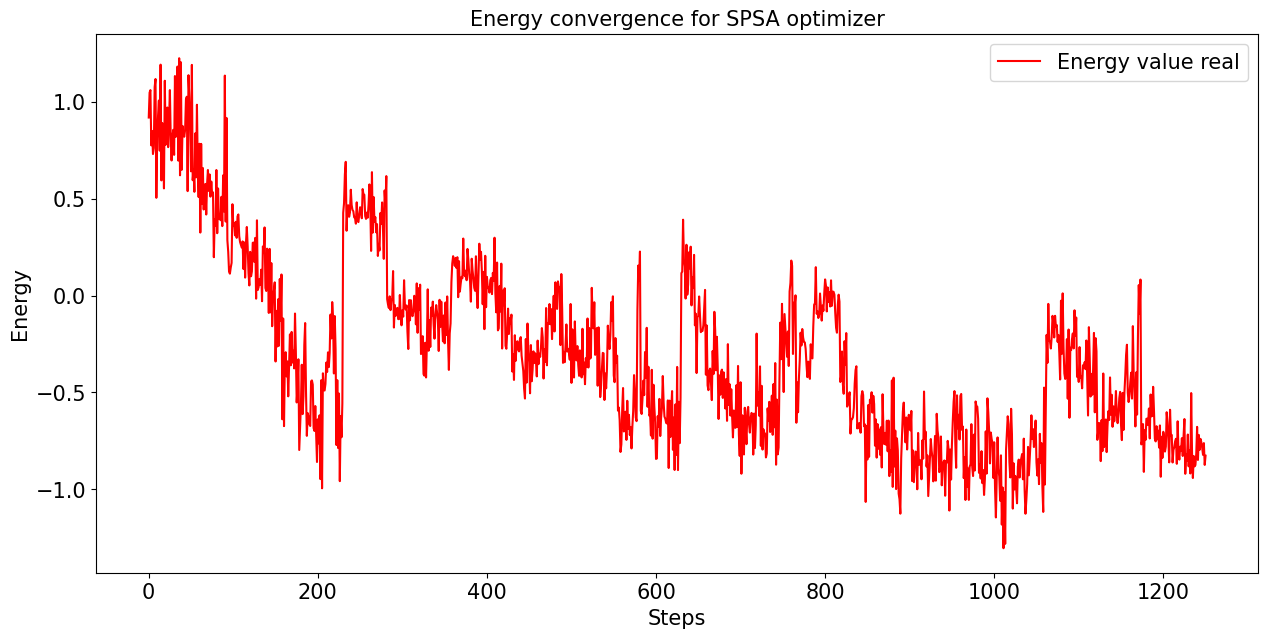

In [9]:
'''Qiskit_code_cell'''

plot_values = intermediate_info['energy'] if not CONFIGURATION['JSON_RESULT'] else result['optimizer_history']['energy']
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(plot_values)), plot_values, label="Energy value real", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for SPSA optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

Los resultados obtenidos con el computador cuántico no son muy fiables puesto que tiene ciertas limitaciones en la ejecución del algoritmo de optimización como el número de iteraciones, esta limitación impacta en el tiempo máximo de ejecución que se ha dispuesto para cada trabajo que se envía de tal manera que si se sobrepasa ese límite de tiempo la ejecución se para y nos devuelve el resultado en ese preciso instante, es por ello que los resultados no se acercan a los esperados.


Además el algoritmo **Rotosolve** no esta disponible en el servidor remoto por lo que debemos seleccionar otro algoritmo de optimización disponible como el **SPSA**.


Como solución a estas limitaciones impuestas, vamos a obtener las condiciones del ordenador cuántico real y las vamos a aplicar al simulador local, ésto es, nos descargaremos el ruido del ordenador cuántico remoto, obtendremos sus puertas básicas para traducir nuestro circuito a ese tipo de puertas básicas y obtendremos el mapa de conexiones entre las puertas, con todo esto aplicado al simulador local no tendremos problemas de tiempo de ejecución ni restricciones en la selección del algoritmo de optimización.


Usaremos el mismo <i>backend</i> que hemos usado hasta ahora pero en dos vertientes: el computador cuántico real (<b>ibmq_lima</b>) y su versión simulada (<b>fake_lima</b>), ambos tienen los parámetros que deseamos obtener para el simulador local.


Debemos tener presente el concepto de <b>transpilación de un circuito cuántico</b>. Los computadores cuánticos, en general, no tienen implementadas todas las puertas cuánticas disponibles, es un esfuerzo bastante grande obtener puertas con una fiabilidad alta y por ello la implementación de las puertas cuánticas en un dispositivo real puede ser my costosa. Por eso, debemos traducir nuestro circuito complejo al conjunto de puertas disponibles del computador cuántico remoto.

(sec_Ejecución_de_VQE_con_Rotosolve_simulando_el_ruido_de_un_computador_cuántico_real)= 
### Ejecución de VQE con Rotosolve simulando el ruido de un computador cuántico real

No es necesario enviar el circuito cuántico a un ordenador real, podemos simular este escenario añadiendo el ruido que se produce en ese entorno, con ello obtenemos unos resultados inmediatos y más fiables.

:::::{tab-set}
::::{tab-item} Qiskit
```python

noise_model = NoiseModel.from_backend(backend) # modelo de ruido
coupling_map = backend.configuration().coupling_map # configuración de conexiones de puertas cuánticas
basis_gates = noise_model.basis_gates # puertas básicas

#print(noise_model)
print("\nCoupling map: ", coupling_map)
print("\nBasis gates: ", basis_gates)
```
::::
:::::


In [10]:
'''Qiskit_code_cell'''

noise_model = NoiseModel.from_backend(backend) # modelo de ruido
coupling_map = backend.configuration().coupling_map # configuración de conexiones de puertas cuánticas
basis_gates = noise_model.basis_gates # puertas básicas

#print(noise_model)
print("\nCoupling map: ", coupling_map)
print("\nBasis gates: ", basis_gates)


Coupling map:  [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

Basis gates:  ['cx', 'id', 'kraus', 'measure', 'qerror_loc', 'quantum_channel', 'reset', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'sx', 'x']


Podemos obtener información detalla del ordenador cuántico sobre el que deseamos ejecutar nuestro Hamiltoniano:

:::::{tab-set}
::::{tab-item} Qiskit
```python

print("Backend name: ", backend.configuration().backend_name)
# print(backend.configuration().hamiltonian['description'])
display.display(Latex(backend.configuration().hamiltonian["h_latex"]))
```
::::
:::::


In [11]:
'''Qiskit_code_cell'''

print("Backend name: ", backend.configuration().backend_name)
# print(backend.configuration().hamiltonian['description'])
display.display(Latex(backend.configuration().hamiltonian["h_latex"]))

Backend name:  qasm_simulator(fake_lima)


<IPython.core.display.Latex object>

Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just $\ket{0}$ and $\ket{1}$. The Pauli operators are generalized via the following set of transformations: $(\mathbb{I}-\sigma_{i}^z)/2 \rightarrow O_i \equiv b^\dagger_{i} b_{i}$,
$\sigma_{+} \rightarrow b^\dagger$, $\sigma_{-} \rightarrow b$, $\sigma_{i}^X \rightarrow b^\dagger_{i} + b_{i}$. Qubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions. Quantities are returned in angular frequencies, with units 2*$\pi$*GHz. WARNING: Currently not all system Hamiltonian information is available to the public, missing values have been replaced with 0.

:::::{tab-set}
::::{tab-item} Qiskit
```python

intermediate_info_noise = {
    'nfev': [],
    'parameters': [],
    'mean': [],
    #'stddev': []
}

def callback_noisy(nfev, parameters, mean, stddev):
    intermediate_info_noise['nfev'].append(nfev)
    intermediate_info_noise['parameters'].append(parameters)
    intermediate_info_noise['mean'].append(mean)
    #intermediate_info_noise['stddev'].append(stddev)

optimizer_noise = Rotosolve(max_steps = 200, step_size = 3)

sim_backend = Aer.get_backend('aer_simulator')

qi = QuantumInstance(backend = sim_backend, 
                     shots=1024,
                     seed_simulator=seed, 
                     seed_transpiler=seed, 
                     coupling_map = coupling_map, 
                     #measurement_error_mitigation_cls = CompleteMeasFitter, # Mitigación de errores
                     #cals_matrix_refresh_period = 30, # Mitigación de errores
                     noise_model = noise_model)

# Transpilación del circuito ansatz para su representación en función de las puertas base del backend
# y selección del nivel de optimización (0 --> sin optimización, 3 --> optimización máxima)
optimization_level = 0 # sin optimización
#optimization_level = 3 # con optimización máxima
trans_ansatz = transpile(ansatz, basis_gates = basis_gates, optimization_level = optimization_level) 

vqe_min_energy = VQE(estimator = Estimator(),
                     ansatz = trans_ansatz,
                     optimizer = optimizer_noise, 
                     initial_point = initial_point,
                     callback = callback_noisy)

vqe_min_energy.quantum_instance = qi

result_sim = vqe_min_energy.compute_minimum_eigenvalue(op_H)

print("==============================================")
print('\nEigenvalue:', result_sim.eigenvalue)
print('Eigenvalue real part:', result_sim.eigenvalue.real)
print("E_G =", result_sim.optimal_value)
```
::::
:::::


In [12]:
'''Qiskit_code_cell'''

intermediate_info_noise = {
    'nfev': [],
    'parameters': [],
    'mean': [],
    #'stddev': []
}

def callback_noisy(nfev, parameters, mean, stddev):
    intermediate_info_noise['nfev'].append(nfev)
    intermediate_info_noise['parameters'].append(parameters)
    intermediate_info_noise['mean'].append(mean)
    #intermediate_info_noise['stddev'].append(stddev)

optimizer_noise = Rotosolve(max_steps = 200, step_size = 3)

sim_backend = Aer.get_backend('aer_simulator')

qi = QuantumInstance(backend = sim_backend, 
                     shots=1024,
                     seed_simulator=seed, 
                     seed_transpiler=seed, 
                     coupling_map = coupling_map, 
                     #measurement_error_mitigation_cls = CompleteMeasFitter, # Mitigación de errores
                     #cals_matrix_refresh_period = 30, # Mitigación de errores
                     noise_model = noise_model)

# Transpilación del circuito ansatz para su representación en función de las puertas base del backend
# y selección del nivel de optimización (0 --> sin optimización, 3 --> optimización máxima)
optimization_level = 0 # sin optimización
#optimization_level = 3 # con optimización máxima
trans_ansatz = transpile(ansatz, basis_gates = basis_gates, optimization_level = optimization_level) 

vqe_min_energy = VQE(estimator = Estimator(),
                     ansatz = trans_ansatz,
                     optimizer = optimizer_noise, 
                     initial_point = initial_point,
                     callback = callback_noisy)

vqe_min_energy.quantum_instance = qi

result_sim = vqe_min_energy.compute_minimum_eigenvalue(op_H)

print("==============================================")
print('\nEigenvalue:', result_sim.eigenvalue)
print('Eigenvalue real part:', result_sim.eigenvalue.real)
print("E_G =", result_sim.optimal_value)

Rotosolve algorithm for optimizing a given value


Step 0. Current expectation value: -4.09038569


Step 3. Current expectation value: -4.09038569


Step 6. Current expectation value: -4.09038569


Step 9. Current expectation value: -4.09038569


Step 12. Current expectation value: -4.09038569


Step 15. Current expectation value: -4.09038569


Step 18. Current expectation value: -4.09038569


Step 21. Current expectation value: -4.09038569


Step 24. Current expectation value: -4.09038569


Step 27. Current expectation value: -4.09038569


Step 30. Current expectation value: -4.09038569


Step 33. Current expectation value: -4.09038569


Step 36. Current expectation value: -4.09038569


Step 39. Current expectation value: -4.09038569


Step 42. Current expectation value: -4.09038569


Step 45. Current expectation value: -4.09038569


Step 48. Current expectation value: -4.09038569


Step 51. Current expectation value: -4.09038569


Step 54. Current expectation value: -4.09038569


Step 57. Current expectation value: -4.09038569


Step 60. Current expectation value: -4.09038569


Step 63. Current expectation value: -4.09038569


Step 66. Current expectation value: -4.09038569


Step 69. Current expectation value: -4.09038569


Step 72. Current expectation value: -4.09038569


Step 75. Current expectation value: -4.09038569


Step 78. Current expectation value: -4.09038569


Step 81. Current expectation value: -4.09038569


Step 84. Current expectation value: -4.09038569


Step 87. Current expectation value: -4.09038569


Step 90. Current expectation value: -4.09038569


Step 93. Current expectation value: -4.09038569


Step 96. Current expectation value: -4.09038569


Step 99. Current expectation value: -4.09038569


Step 102. Current expectation value: -4.09038569


Step 105. Current expectation value: -4.09038569


Step 108. Current expectation value: -4.09038569


Step 111. Current expectation value: -4.09038569


Step 114. Current expectation value: -4.09038569


Step 117. Current expectation value: -4.09038569


Step 120. Current expectation value: -4.09038569


Step 123. Current expectation value: -4.09038569


Step 126. Current expectation value: -4.09038569


Step 129. Current expectation value: -4.09038569


Step 132. Current expectation value: -4.09038569


Step 135. Current expectation value: -4.09038569


Step 138. Current expectation value: -4.09038569


Step 141. Current expectation value: -4.09038569


Step 144. Current expectation value: -4.09038569


Step 147. Current expectation value: -4.09038569


Step 150. Current expectation value: -4.09038569


Step 153. Current expectation value: -4.09038569


Step 156. Current expectation value: -4.09038569


Step 159. Current expectation value: -4.09038569


Step 162. Current expectation value: -4.09038569


Step 165. Current expectation value: -4.09038569


Step 168. Current expectation value: -4.09038569


Step 171. Current expectation value: -4.09038569


Step 174. Current expectation value: -4.09038569


Step 177. Current expectation value: -4.09038569


Step 180. Current expectation value: -4.09038569


Step 183. Current expectation value: -4.09038569


Step 186. Current expectation value: -4.09038569


Step 189. Current expectation value: -4.09038569


Step 192. Current expectation value: -4.09038569


Step 195. Current expectation value: -4.09038569


Step 198. Current expectation value: -4.09038569

Eigenvalue: -4.090385693670181
Eigenvalue real part: -4.090385693670181
E_G = -4.090385693670181


Lel resultado de la energía es bastante bueno y converge muy rápido, el algoritmo de optimización Rotosolve ha hecho que el proceso de convergencia dure unas pocas iteraciones.

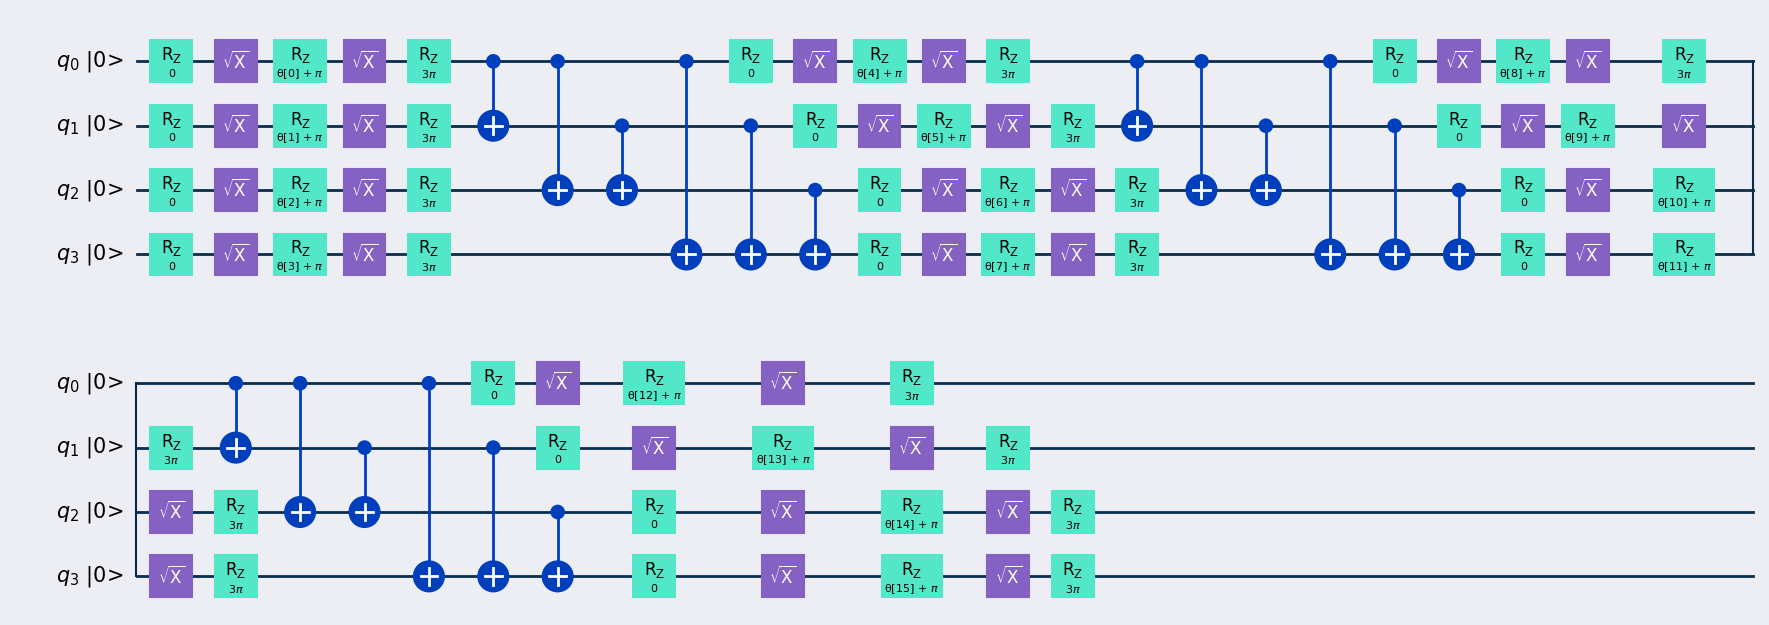

In [13]:
vqe_min_energy.ansatz.draw('mpl', initial_state=True, style=qspain())

Con la siguiente gráfica, podemos ver que la convergencia ya es final en las primeras iteraciones y para a optimizar el décimo dígito decimal.

:::::{tab-set}
::::{tab-item} Qiskit
```python

sim_noisy_values = optimizer_noise.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_noisy_values)), sim_noisy_values, label="Energy value", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
#plt.ylim([np.min(sim_noisy_values), np.max(sim_noisy_values)])
plt.title('Energy convergence for Rotosolve optimizer with noise (Zoom in)', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()
```
::::
:::::


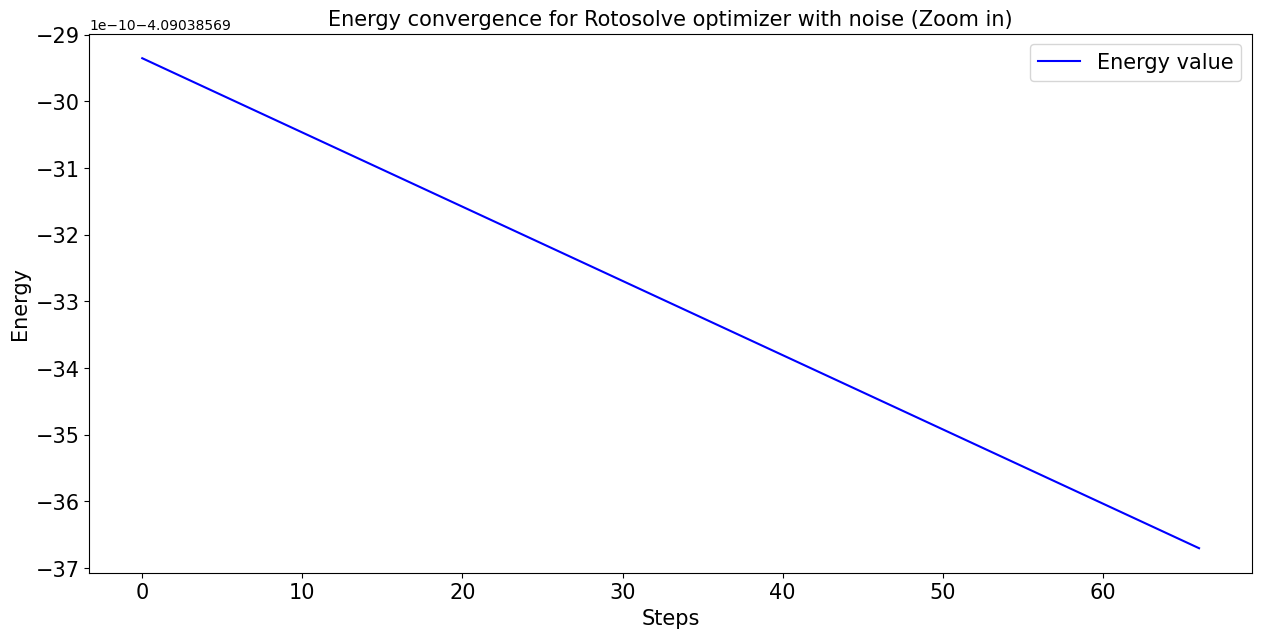

In [14]:
'''Qiskit_code_cell'''

sim_noisy_values = optimizer_noise.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_noisy_values)), sim_noisy_values, label="Energy value", color='blue')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
#plt.ylim([np.min(sim_noisy_values), np.max(sim_noisy_values)])
plt.title('Energy convergence for Rotosolve optimizer with noise (Zoom in)', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

En la siguiente gráfica vemos como la energía ya ha llegado al mínimo en las primeras iteraciones y se mantiene estable en las iteraciones siguientes:

:::::{tab-set}
::::{tab-item} Qiskit
```python

sim_noisy_values = optimizer_noise.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_noisy_values)), sim_noisy_values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

eig_val = result_sim.eigenvalue.real
plt.ylim([eig_val - 1e-4, eig_val + 1e-4])
plt.title('Energy convergence for Rotosolve optimizer with noise (Zoom out)', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()
```
::::
:::::


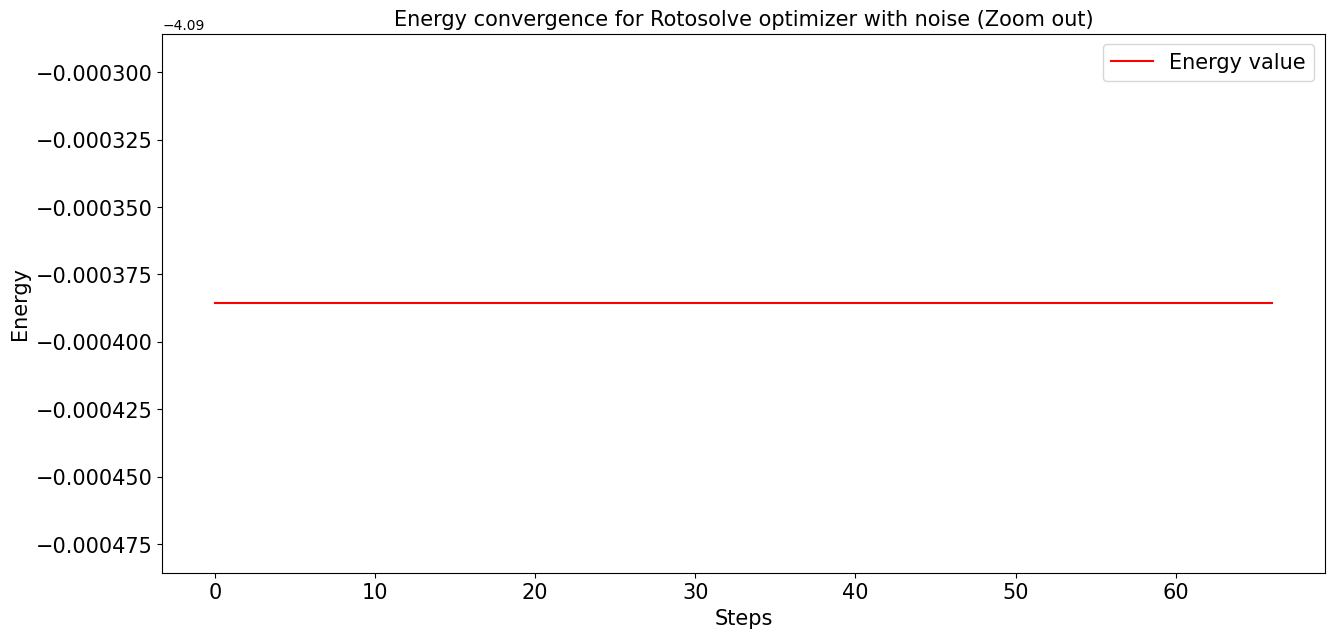

In [15]:
'''Qiskit_code_cell'''

sim_noisy_values = optimizer_noise.energy_values
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_noisy_values)), sim_noisy_values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)

eig_val = result_sim.eigenvalue.real
plt.ylim([eig_val - 1e-4, eig_val + 1e-4])
plt.title('Energy convergence for Rotosolve optimizer with noise (Zoom out)', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

<table style='margin: 0 auto; font-size:11pt'>
  <tr>
      <th style="text-align:center">Algoritmo<br/>optimización</th>
      <th style="text-align:center">Dispositivo</th>
      <th style="text-align:center">Ruido<br/>incorporado</th>
      <th style="text-align:center">Optimizacion<br/>activada</th>
      <th style="text-align:center">Num.<br/>Iteraciones</th>
      <th style="text-align:center">Energía mínima <br/>(autovalor)</th>
  </tr>
  <tr>
    <td style="text-align:center"><b>SPSA</b></td>
    <td style="text-align:center">Aer Simulator</td>
    <td style="text-align:center"><i class='fa fa-close' aria-hidden="true" style='color: #ff392e'></i></td>
    <td style="text-align:center"><i class='fa fa-close' aria-hidden="true" style='color: #ff392e'></i></td>
    <td style="text-align:center">300</td>
    <td style="text-align:center">-4.092961599426855</td>
  </tr>
  <tr>
    <td style="text-align:center"><b>Rotosolve</b></td>
    <td style="text-align:center">Aer Simulator</td>
    <td style="text-align:center"><i class='fa fa-close' aria-hidden="true" style='color: #ff392e'></i></td>
    <td style="text-align:center"><i class='fa fa-close' aria-hidden="true" style='color: #ff392e'></i></td>
    <td style="text-align:center">66</td>
    <td style="text-align:center">-4.090385692923965</td>
  </tr>
  <tr>
    <td style="text-align:center"><b>Rotosolve</b></td>
    <td style="text-align:center">Aer Simulator + ibmq_lima</td>
    <td style="text-align:center"><i class="fa fa-check" aria-hidden="true" style='color: #4ed34e'></i></td>
    <td style="text-align:center"><i class='fa fa-close' aria-hidden="true" style='color: #ff392e'></i></td>
    <td style="text-align:center">66</td>
    <td style="text-align:center"><b>-4.090385694416840</b></td>
  </tr>
  <tr>
    <td style="text-align:center"><b>Rotosolve</b></td>
    <td style="text-align:center">Aer Simulator + ibmq_lima</td>
    <td style="text-align:center"><i class="fa fa-check" aria-hidden="true" style='color: #4ed34e'></i></td>
    <td style="text-align:center"><i class="fa fa-check" aria-hidden="true" style='color: #4ed34e'></i></td>
    <td style="text-align:center">66</td>
    <td style="text-align:center">-4.090385693670182</td>
  </tr>
  <tr>
    <td style="text-align:center"><b>Rotosolve</b></td>
    <td style="text-align:center">Aer Simulator + FakeLima</td>
    <td style="text-align:center"><i class="fa fa-check" aria-hidden="true" style='color: #4ed34e'></i></td>
    <td style="text-align:center"><i class='fa fa-close' aria-hidden="true" style='color: #ff392e'></i></td>
    <td style="text-align:center">66</td>
    <td style="text-align:center">-4.090385693670182</td>
  </tr>
  <tr>
    <td style="text-align:center"><b>Rotosolve</b></td>
    <td style="text-align:center">Aer Simulator + FakeLima</td>
    <td style="text-align:center"><i class="fa fa-check" aria-hidden="true" style='color: #4ed34e'></i></td>
    <td style="text-align:center"><i class="fa fa-check" aria-hidden="true" style='color: #4ed34e'></i></td>
    <td style="text-align:center">66</td>
    <td style="text-align:center">-4.090385693670182</td>
  </tr>
</table>

Tras una serie de pruebas, la combinación del simulador local con los parámetros del computador cuántico real (<b>Aer Simulator + ibmq_lima</b>) dan los mejores resultados, es un hecho inesperado porque podemos llegar a pensar que los parámetros del computador cuántico simulado pueden estar más afinados. Por otra parte, resulta curioso el hecho de haber desactivado la optimización para obtener mejores resultados, esto nos dice que el proceso de optimización genera algún tipo de ruido adicional que penaliza el valor de la energía.


De igual manera, se ha obtenido una optimización muy fuerte desde la primera iteración del algoritmo Rotosolve, es decir, desde el inicio se ha obtenido el valor mínimo de la energía que buscábamos, haciendo que en las siguientes iteraciones se refine su décimo decimal, es una gran sorpresa la rápida convergencia del algoritmo Rotosolve a su valor mínimo.


En la primera gráfica, ya se observa que el descenso de la energía aparece desde el décimo dígito decimal cayendo en picado. En la segunda gráfica se muestra una imagen general de la curva de optimización y vemos que la gráfica es plana porque ya se encuentra en su valor mínimo desde la primera iteración.


- El valor de la energía mínima es: <b>-4.090385694416840</b>

(sec_Conclusiones_optimizadores)= 
## Conclusiones

Hemos visto cómo los optimizadores puede hacer que llegemos a una solución con pocas iteraciones, independientemente del framework de que usemos ya sea Qiskit o Pennylane.
<br/>
<br/>
Usar un optimizador un circuito no es nada trivial, es podible que un optimizador funcione mejor o peor con un ansatz, por ello hay que buscar un consenso entre un buen ansatz que se adapte al problema y un optimizador que sea capaz de obtener el resultado esperado en pocas iteraciones.

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table

---
Authors:

Irais Bautista ([CESGA](http://www.cesga.es)), Sergio Martínez ([BIFi-UNIZAR](https://bifi.es/es/)), Jaime Scharfhausen ([UAM](https://www.uam.es/uam/inicio)) y Alejandro Jaramillo ([CSUC](https://www.csuc.cat/es))

<img src="https://quantumspain-project.es/wp-content/uploads/2022/11/CESGA.png" width="150px">
<img src="http://bifi.es/wp-content/uploads/2016/11/logo_vectorial-web.png" width="200px">
<img src="https://www.iib.uam.es/iiblf6theme-theme/images/custom/logo-uam.png" width = "200px">
<img src="https://www.csuc.cat/sites/default/files/2021-02/CSUC_logo_corporatiu_0.png" width = "200px">


---
::::{figure} https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png
:width: 2000px
:align: center
::::

<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<center>
<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />
</center>